# PPO Original Implementation

In [1]:
from argparse import ArgumentParser
import numpy as np
import wandb
from gridworld_ctf_mvp import GridworldCtf
import os
import time
import torch as T
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR
from torch.distributions.categorical import Categorical
import utils as ut
import multiprocessing as mp
from collections import defaultdict
from IPython.display import clear_output

### Policy Network

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, n_channels=4, n_actions=8, alpha=0.0003, device='cpu'):
        super(PolicyNet, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*2*2 + 12, 256)
        self.action_head = nn.Linear(256, n_actions)
        self.value_head = nn.Linear(256, 1)
        self.optimizer = Adam(self.parameters(), lr=alpha)
        self.device = device
        
    def forward(self, t, t2, print_shapes=False):
        if print_shapes:
            print(f'input shape: {t.shape}')

        t = T.relu(self.conv1(t))
        if print_shapes:
            print(f'shape after conv 1: {t.shape}')
        
        t = T.relu(self.conv2(t))
        if print_shapes:
            print(f'shape after conv 2: {t.shape}')
        
        t = t.view(-1, 32*2*2)
        if print_shapes:
            print(f'shape after flattening: {t.shape}')

        # Add in metadata
        t = T.concat((t, t2), dim=1)
        if print_shapes:
            print(f'shape after adding metadata: {t.shape}')
        
        t = T.relu(self.fc1(t))
        if print_shapes:
            print(f'shape after FC 1 layer: {t.shape}')
        
        action_scores = T.softmax(self.action_head(t), dim=-1)
        if print_shapes:
            print(f'action scores shape: {action_scores.shape}')

        state_values = self.value_head(t)
        if print_shapes:
            print(f'state values shape: {state_values.shape}')

        # Categorical below samples an action according to the multinomial distribution
        return Categorical(action_scores).sample(), action_scores, state_values
        

In [3]:
class PolicyNet(nn.Module):
    def __init__(self, n_channels=4, n_actions=8, alpha=0.0003, device='cpu'):
        super(PolicyNet, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(16*4*4 + 12, 64)
        self.action_head = nn.Linear(64, n_actions)
        self.value_head = nn.Linear(64, 1)
        self.optimizer = Adam(self.parameters(), lr=alpha)
        self.device = device
        
    def forward(self, t, t2, print_shapes=False):
        if print_shapes:
            print(f'input shape: {t.shape}')

        t = T.relu(self.conv1(t))
        if print_shapes:
            print(f'shape after conv 1: {t.shape}')
        
        t = t.view(-1, 16*4*4)
        if print_shapes:
            print(f'shape after flattening: {t.shape}')

        # Add in metadata
        t = T.concat((t, t2), dim=1)
        if print_shapes:
            print(f'shape after adding metadata: {t.shape}')
        
        t = T.relu(self.fc1(t))
        if print_shapes:
            print(f'shape after FC 1 layer: {t.shape}')
        
        action_scores = T.softmax(self.action_head(t), dim=-1)
        if print_shapes:
            print(f'action scores shape: {action_scores.shape}')

        state_values = self.value_head(t)
        if print_shapes:
            print(f'state values shape: {state_values.shape}')

        # Categorical below samples an action according to the multinomial distribution
        return Categorical(action_scores).sample(), action_scores, state_values
        

In [4]:
x1 = T.rand(1, 6, 6)
x2 = T.rand(1, 12)

print(x1.shape)
print(x2.shape)

torch.Size([1, 6, 6])
torch.Size([1, 12])


In [5]:
pn = PolicyNet(n_channels=1)
pn.forward(x1, x2)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


(tensor([1]),
 tensor([[0.1254, 0.1209, 0.1314, 0.1341, 0.1275, 0.1129, 0.1085, 0.1394]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[-0.0360]], grad_fn=<AddmmBackward0>))

### Feed-forward network

In [6]:
class PolicyNet(nn.Module):
    def __init__(self, n_channels=4, n_actions=8, alpha=0.0003, device='cpu'):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(180 + 12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.action_head = nn.Linear(64, n_actions)
        self.value_head = nn.Linear(64, 1)
        self.optimizer = Adam(self.parameters(), lr=alpha)
        self.device = device

        self.action_head.weight.data.fill_(0.0)
        self.value_head.weight.data.fill_(0.0)
        
    def forward(self, x, x2, print_shapes=False):
        # Flatten state
        x = x.view(x.shape[0], 180)

        # Add in metadata
        x = T.concat((x, x2), dim=1)
        x = T.relu(self.fc1(x))
        x = T.relu(self.fc2(x))

        # Get action scores and state values
        action_scores = T.softmax(self.action_head(x), dim=-1)
        state_values = self.value_head(x)

        # Categorical below samples an action according to the  
        return Categorical(action_scores).sample(), action_scores, state_values
        

In [7]:
x1 = T.rand(100, 5, 6, 6)
x2 = T.rand(100, 12)

pn = PolicyNet()
pn.forward(x1, x2)

(tensor([7, 4, 2, 6, 4, 4, 7, 4, 0, 5, 7, 7, 1, 2, 3, 5, 4, 2, 6, 1, 1, 6, 1, 6,
         2, 7, 5, 3, 3, 1, 7, 3, 5, 1, 6, 1, 3, 5, 1, 0, 7, 5, 4, 3, 5, 6, 0, 1,
         0, 1, 7, 0, 7, 6, 5, 0, 3, 1, 7, 7, 4, 2, 4, 4, 1, 1, 1, 5, 2, 0, 7, 3,
         5, 4, 6, 7, 6, 7, 4, 7, 2, 0, 7, 4, 5, 1, 5, 7, 3, 5, 2, 6, 7, 1, 2, 2,
         2, 5, 7, 4]),
 tensor([[0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1362, 0.1200, 0.1355],
         [0.1211, 0.1367, 0.1152, 0.1135, 0.1218, 0.1

In [8]:
pn.value_head.weight.data

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Memory

In [9]:
class PPOMemory:
    def __init__(self, batch_size, device='cpu'):
        self.states_grid = []
        self.states_metadata = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size
        self.device = device

    def generate_batches(self):
        n_states = len(self.states_grid)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return T.cat([t for t in self.states_grid]).to(self.device), \
                T.cat([t for t in self.states_metadata]).to(self.device), \
                np.array(self.probs), \
                np.array(self.vals), \
                np.array(self.actions), \
                np.array(self.rewards), \
                np.array(self.dones), \
                batches

    def store_memory(self, 
                    state_grid, 
                    state_metadata, 
                    action, 
                    probs, 
                    vals, 
                    reward, 
                    done):
        self.states_grid.append(state_grid)
        self.states_metadata.append(state_metadata)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states_grid = []
        self.states_metadata = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


In [10]:
memory = PPOMemory(5)

for x in range(20):
    t = T.tensor([x, 1])
    memory.store_memory(t, t, x, x, x, x, x)

state_grid, \
state_metadata, \
old_prob_arr, \
vals_arr,\
action_arr, \
reward_arr, \
dones_arr, \
batches = memory.generate_batches()

print(batches)

[array([19, 18,  2, 11, 13]), array([ 4, 10,  9, 16,  0]), array([ 7,  1, 12,  8, 17]), array([ 6, 15,  3,  5, 14])]


### PPO Agent Class

In [5]:
class PPOAgent:
    def __init__(self, 
                 n_actions, 
                 n_channels=4,
                 gamma=0.95, 
                 alpha=0.00003, 
                 gae_lambda=0.95,
                 policy_clip=0.2, 
                 batch_size=512, 
                 n_epochs=3):

        self.n_channels = n_channels
        self.alpha = alpha
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        # Build actor and critic networks
        self.policy_network = PolicyNet(n_channels=n_channels,
                                        alpha=self.alpha,
                                        n_actions=n_actions)
        self.memory = PPOMemory(batch_size)
       
    def store_memory(self, 
                    state_grid,
                    state_metadata,
                    action, 
                    probs, 
                    vals, 
                    reward, 
                    done):
        self.memory.store_memory(state_grid,
                                    state_metadata,
                                    action,
                                    probs, 
                                    vals, 
                                    reward, 
                                    done)


    def choose_action(self, state, state2):
        action, probs, value = self.policy_network(state, state2)

        probs = T.squeeze(probs)[action].item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value


    def learn(self):
        for _ in range(self.n_epochs):
            state_grid, \
            state_metadata, \
            old_prob_arr, \
            vals_arr,\
            action_arr, \
            reward_arr, \
            dones_arr, \
            batches = self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    # a[t] = discount * (r[t] + gamma * values[t+1] * (1 - done) - values[k])
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.policy_network.device)

            values = T.tensor(values).to(self.policy_network.device)
            for batch in batches:

                grid_states = state_grid[batch]
                metadata_states = state_metadata[batch]

                old_probs_batch = T.tensor(old_prob_arr[batch]).to(self.policy_network.device)
                actions_batch = T.tensor(action_arr[batch], dtype=T.int64).to(self.policy_network.device)

                _, new_probs_batch, critic_value = self.policy_network(grid_states, metadata_states)
                
                actions_vw = actions_batch.view(len(batch), 1)

                prob_ratio = new_probs_batch.gather(1, actions_vw) / old_probs_batch.view(len(batch), 1)

                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.policy_network.optimizer.zero_grad()
                total_loss.backward()
                self.policy_network.optimizer.step()

        self.memory.clear_memory()     

        return total_loss


In [6]:
class PPOOpponent:
    def __init__(self, 
                 n_channels,
                 n_actions,
                 weights):

        # Build polcicy network
        self.policy_network = PolicyNet(n_channels=n_channels, n_actions=n_actions)
        self.policy_network.load_state_dict(weights)

    def choose_action(self, state, state2):
        action, probs, value = self.policy_network(state, state2)

        probs = T.squeeze(probs)[action].item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value


### Training Script

In [8]:
def reward_shaping(agent_idx, env):

    DISTANCE_PENALTY = -1.0
    max_distance_from_flags = env.GRID_SIZE - 2
    
    if env.has_flag[agent_idx]:
        own_flag_pos = env.FLAG_POSITIONS[0]
        distance_to_own_flag = env.agent_distance_to_xy(agent_idx, own_flag_pos)
        reward = distance_to_own_flag/max_distance_from_flags * DISTANCE_PENALTY
    else:
        opp_flag_pos = env.FLAG_POSITIONS[1]
        distance_to_opp_flag = env.agent_distance_to_xy(agent_idx, opp_flag_pos)
        reward = distance_to_opp_flag/max_distance_from_flags * DISTANCE_PENALTY

    return reward


In [9]:
def train_ppo(env,
            agent,
            opponent,
            n_episodes,
            n_actors,
            learning_steps=20,
            max_steps=1000,
            use_ego_state=False,
            verbose_episodes=5,
            device='cpu'):
    """
    Train PPO agent.
    """

    step_count = 0
    done_count = 0

    training_metrics = {
        "score_history": [], 
        "losses": [],
        "team_1_captures": [], 
        "team_2_captures": [],
        "team_1_tags": [],
        "team_2_tags": [],
        "episode_step_counts": [],
        "agent_tag_count": defaultdict(list),
        "agent_flag_captures": defaultdict(list),
        "agent_blocks_laid": defaultdict(list),
        "agent_blocks_mined": defaultdict(list),
        "agent_avg_distance_to_own_flag": defaultdict(list),
        "agent_avg_distance_to_opp_flag": defaultdict(list),
        "agent_health_pickups": defaultdict(list),
    }

    for i in range(n_episodes):

        # Get rollout
        env.reset()
        done = False
        episode_step_count = 0
        score = 0

        while not done: 
            step_count += 1
            episode_step_count += 1

            # Collect actions for each agent
            grid_states = []
            metadata_states = []
            actions = []
            probs = []
            vals = []
            for agent_idx in np.arange(env.N_AGENTS):
                # Get global and local states
                metadata_state_ = env.get_env_metadata_local(agent_idx) 
                metadata_state = T.from_numpy(metadata_state_).float().to(device)
                
                # Get global and local states
                grid_state_ = env.standardise_state(agent_idx, use_ego_state=use_ego_state)
                grid_state = T.from_numpy(grid_state_).float().to(device)

                #curr_grid_state = env.standardise_state(agent_idx, use_ego_state=use_ego_state, scale_tiles=scale_tiles).reshape(*env_dims) + ut.add_noise(env_dims)

                if env.AGENT_TEAMS[agent_idx]==0:
                    action, prob, val = agent.choose_action(grid_state, metadata_state)
                else:
                    action, prob, val = opponent.choose_action(grid_state, metadata_state)
                    action = 0

                # Append actions and probs
                grid_states.append(grid_state)
                metadata_states.append(metadata_state)
                actions.append(action)
                probs.append(prob)
                vals.append(val)

            # Step the environment
            _, rewards, done = env.step(actions)

            
            # Increment score
            score += sum(rewards)

            # Store each agent experiences
            for agent_idx in np.arange(env.N_AGENTS):
                # Add reward shaping
                # rewards[agent_idx] += reward_shaping(agent_idx, env)

                # Append replay buffer
                if env.AGENT_TEAMS[agent_idx]==0:
                    agent.store_memory(grid_states[agent_idx],
                                        metadata_states[agent_idx],
                                        actions[agent_idx], 
                                        probs[agent_idx],
                                        vals[agent_idx],
                                        rewards[agent_idx], 
                                        done
                                        )

            if done or episode_step_count > max_steps:
                done_count += 1 * done
                done = True

        # Learning
        if step_count % learning_steps == 0 and step_count > agent.batch_size:
            loss = agent.learn().detach().numpy()
        else:
            loss = 0.0

        # Termination -> Append metrics
        if done or episode_step_count > max_steps:
            training_metrics['losses'].append((loss, 0.0))   
            training_metrics['team_1_captures'].append(env.metrics['team_points'][0])
            training_metrics['team_2_captures'].append(env.metrics['team_points'][1])
            training_metrics['team_1_tags'].append(env.metrics['tag_count'][0])
            training_metrics['team_2_tags'].append(env.metrics['tag_count'][1])
            for agent_idx in range(env.N_AGENTS):
                training_metrics["agent_tag_count"][agent_idx].append(env.metrics['agent_tag_count'][agent_idx])
                training_metrics["agent_flag_captures"][agent_idx].append(env.metrics['agent_flag_captures'][agent_idx])
                training_metrics["agent_blocks_laid"][agent_idx].append(env.metrics['agent_blocks_laid'][agent_idx])
                training_metrics["agent_blocks_mined"][agent_idx].append(env.metrics['agent_blocks_mined'][agent_idx])
                training_metrics["agent_avg_distance_to_own_flag"][agent_idx].append(env.metrics['agent_total_distance_to_own_flag'][agent_idx]/env.env_step_count)
                training_metrics["agent_avg_distance_to_opp_flag"][agent_idx].append(env.metrics['agent_total_distance_to_opp_flag'][agent_idx]/env.env_step_count)
                training_metrics["agent_health_pickups"][agent_idx].append(env.metrics['agent_health_pickups'][agent_idx])

        training_metrics['score_history'].append(score)
        training_metrics['episode_step_counts'].append(episode_step_count)

        if i % verbose_episodes == 0:
            clear_output(wait=True)
            print(f"episode: {i+1} \ttotal step count: {step_count} \tepisode step count: {episode_step_count} \tscore: {score} \taverage score: {np.mean(training_metrics['score_history'][-100:])} \tdone count: {done_count}")

        # if avg_score > best_score:
        #     best_score = avg_score
        #     agent.save_models()

    return training_metrics




In [10]:
config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False,
            'GLOBAL_REWARDS': False
        }

env = GridworldCtf(**config)
env.AGENT_TYPE_DAMAGE = {
    0: 0,
    1: 0,
    2: 0
}
env.REWARD_CAPTURE = 100
env.REWARD_STEP = -1
env.WINNING_POINTS = 100
n_actions = env.ACTION_SPACE
n_actions = 4

n_channels = 5
n_actors = 4
n_episodes = 500
learning_steps = 8
max_steps = 128
batch_size = 128
n_epochs = 3
alpha = 0.0003
policy_clip = 0.2
softmax_temp = 0.9
use_ego_state = True

verbose_episodes = 1


agent = PPOAgent(n_actions=n_actions, 
                    n_channels=n_channels,
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs)

    
opponent = PPOOpponent(n_channels=n_channels,
                       n_actions=n_actions,
                        weights=agent.policy_network.state_dict())

training_metrics = train_ppo(env,
                        agent,
                        opponent,
                        n_episodes,
                        n_actors,
                        learning_steps=learning_steps,
                        max_steps=max_steps,
                        use_ego_state=use_ego_state,
                        verbose_episodes=verbose_episodes,
                        device='cpu')

ut.plot_training_performance(training_metrics)



NameError: name 'PPOMemory' is not defined

### Test agent

In [17]:
max_steps = 500
step_count = 0
done= False
device = 'cpu'
env.reset()
total_rewards = 0
while not done:
    step_count += 1

    actions = []
    for agent_idx in np.arange(env.N_AGENTS):
        # Get global and local states
        metadata_state_ = env.get_env_metadata_local(agent_idx) 
        metadata_state = T.from_numpy(metadata_state_).float().to(device)
        
        # Get global and local states
        grid_state_ = env.standardise_state(agent_idx, use_ego_state=use_ego_state)
        grid_state = T.from_numpy(grid_state_).float().to(device)

        #curr_grid_state = env.standardise_state(agent_idx, use_ego_state=use_ego_state, scale_tiles=scale_tiles).reshape(*env_dims) + ut.add_noise(env_dims)

        if env.AGENT_TEAMS[agent_idx]==0:
            action, prob, val = agent.choose_action(grid_state, metadata_state)
        else:
            action, prob, val = opponent.choose_action(grid_state, metadata_state)
            action = 0

        actions.append(action)

    _, rewards, done = env.step(actions)
    total_rewards += rewards[0]

    for agent_idx in np.arange(env.N_AGENTS):
        pass
        # Add reward shaping
        # rewards[agent_idx] += reward_shaping(agent_idx, env)
    env.render(sleep_time=0.01)
    print(step_count, rewards[0], total_rewards)

    if step_count > max_steps:
        done = True


KeyboardInterrupt: 

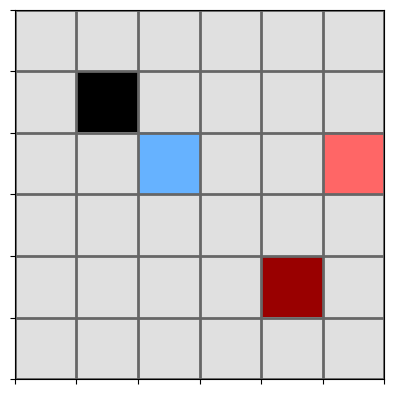

You win!, total score 75


-0.5

In [41]:
env.play(0)
reward_shaping(0, env)

In [11]:
env.reset()
env.standardise_state(0)

array([[[[0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]]], dtype=uint8)

In [13]:
env.standardise_state(1, reverse_grid=True)

array([[[[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]]], dtype=uint8)

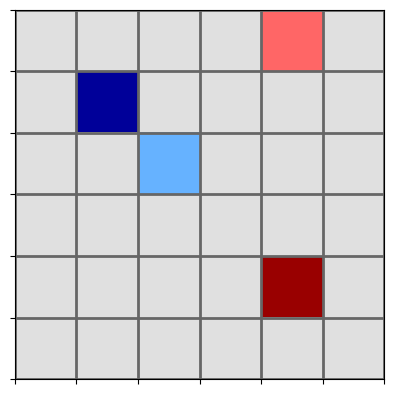

You win!, total score 85


array([[[[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]]], dtype=uint8)

In [49]:
env.play(0)
env.standardise_state(0)

In [11]:
env.standardise_state(0, use_multi_channel=False).shape

(1, 1, 6, 6)

In [12]:
env.standardise_state(0, use_multi_channel=True).shape

(1, 4, 6, 6)

In [28]:
agent.memory.generate_batches()

(tensor([[[[0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0., 0.],
           [0., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0.

In [29]:
state_grid, \
state_metadata, \
old_prob_arr, \
vals_arr,\
action_arr, \
reward_arr, \
dones_arr, \
batches = agent.memory.generate_batches()

In [37]:
done_idx = np.where(dones_arr==True)[0]

In [40]:
state_metadata[done_idx]

tensor([[0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.],
        [0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
        [0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.]])

In [48]:
reward_arr[done_idx]

array([-1, 99, -1])

In [26]:
x = T.zeros((2,) + (4, 4))
x.shape

torch.Size([2, 4, 4])

In [30]:
env.standardise_state(0).shape

(1, 4, 6, 6)

In [40]:
x = T.Tensor([1, 2, 3])
y = T.Tensor([0, 4, 1])

z = T.cat((x.view(3, 1), y.view(3, 1)), dim=1)

print(z)

zz = T.min(z,dim=1)

print(zz.values)

tensor([[1., 0.],
        [2., 4.],
        [3., 1.]])
tensor([0., 2., 1.])
